In [1]:
using SchwarzChristoffel

INFO: Recompiling stale cache file /Users/jeff/.julia/lib/v0.6/SchwarzChristoffel.ji for module SchwarzChristoffel.


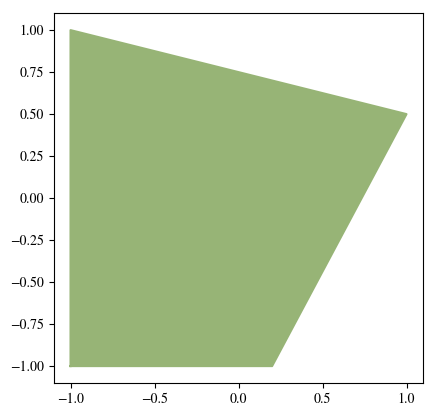

In [4]:
p = Polygon([-1.0,0.2,1.0,-1.0],[-1.0,-1.0,0.5,1.0])
plot(p)

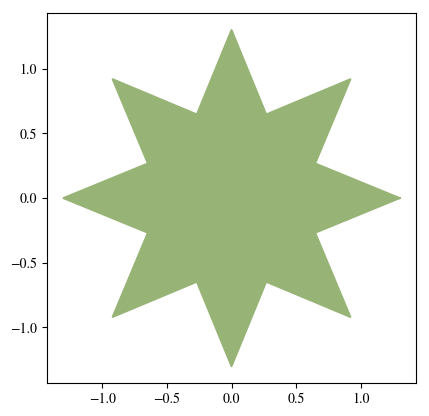

In [5]:
n = 8; dθ = 2π/(2n)
θ = collect(0:dθ:2π-dθ)
w = (1+0.3cos.(n*θ)).*exp.(im*θ)
p = Polygon(w)
plot(p)

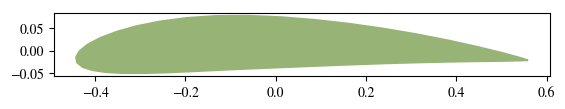

In [3]:
w = naca4(0.04,0.4,0.12;len=1)
p = Polygon(w)
plot(p)

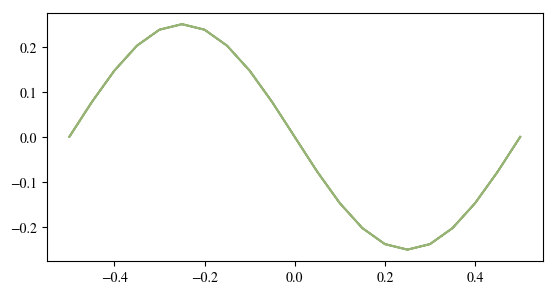

In [2]:
ht = 0.25
nwave = 2
nseg = 20
x = 1.0
len = 1.0
dx = len/nseg
vert = Complex128[]
for j = 1:nseg+1
    push!(vert,x+im*ht*sin(π*nwave*x))
    x -= dx
end
vert = [vert;flipdim(vert[2:end-1],1)]
vert -=mean(vert)
p = Polygon(vert);
plot(p)

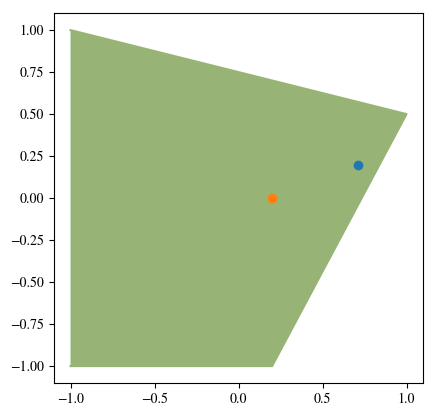

1×2 BitArray{2}:
 true  true

In [6]:
z = [0.71+im*0.2 0.2+im*0]
plot(p)
PyPlot.plot(real.(z),imag.(z),marker="o")
isinpoly.(z,p,1e-5)

In [4]:
m = ExteriorMap(p);

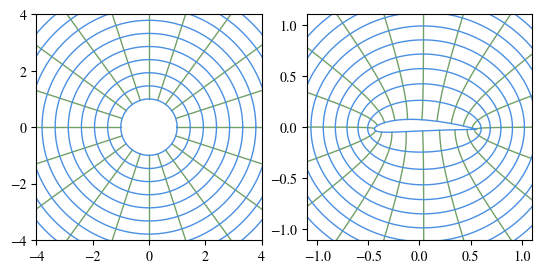

In [5]:
conformal_grid(m)

In [11]:
m = ExteriorMap(p;tol=1e-12)

Exterior map with
   vertices: (-1.0,-1.0), (0.2,-1.0), (1.0,0.5), (-1.0,1.0), 
   interior angles/π: 0.5, 0.656, 0.422, 0.422, 
   prevertices on circle: (1.0,0.0), (0.3764,-0.9265), (-0.9024,-0.4309), (-0.1868,0.9824), 
   constant = 0.6722 + 0.7669im, accuracy = 1.0e-12, 
   number of multipole coefficients = 12


In [9]:
prev, C = parameters(m)

(Complex{Float64}[1.0+0.0im, 0.376406-0.926455im, -0.902383-0.430935im, -0.186756+0.982406im], 0.6722109863402015 + 0.7668866078562682im)

In [42]:
area(m)/ccoeff[1]

2.3639234904370356 - 0.0im

In [45]:
ccoeff, dcoeff = coefficients(m);

In [46]:
ccoeff

14-element Array{Complex{Float64},1}:
      1.12786+0.0im        
 -1.42493e-16+4.60899e-17im
 -3.13044e-17-3.13044e-16im
  6.26088e-17-3.86088e-16im
  3.30026e-16-3.13044e-17im
   5.0087e-17+1.37739e-16im
 -3.96522e-17-3.13044e-17im
  9.98759e-17-5.96274e-18im
     0.202134+1.75453e-14im
 -7.43133e-18-1.09806e-17im
  1.41027e-17+8.39839e-17im
 -6.77881e-17+1.23623e-16im
 -1.93438e-16+7.8648e-18im 
 -3.88048e-17-9.57267e-17im

In [5]:
zeta = [0.1,0.5-0.75im,-0.25-0.3im]
dz, ddz = evalderiv(zeta,m,true);
dz

3-element Array{Complex{Float64},1}:
  67.2068+76.6284im 
 -1.11666+0.544576im
  3.99129-5.30641im 

In [6]:
zeta = [1.0+3.0im,-2.0-2.0im,0.0+1.1im]
z = evaluate(zeta,m)

3-element Array{Complex{Float64},1}:
   0.81614+3.02956im 
  -2.25237-2.08523im 
 -0.333104+0.975837im

In [16]:
zeta = collect(1.1:0.1:2.0) + 0.1im
dz,ddz = evalderiv(zeta,m)
dz

10-element Array{Complex{Float64},1}:
 0.872356-0.394475im 
 0.901724-0.289355im 
 0.925562-0.217994im 
 0.944059-0.168264im 
 0.958255-0.132657im 
  0.96919-0.106522im 
 0.977695-0.0869128im
 0.984389-0.0719115im
 0.989723-0.0602376im
 0.994025-0.0510144im

In [11]:
z = evaluate(zeta,m)

3-element Array{Complex{Float64},1}:
   0.81614+3.02956im 
  -2.25237-2.08523im 
 -0.333104+0.975837im

In [7]:
mean([sum(ccoeff.*zeta[i].^(1:-1:-m.ncoeff))-z[i] for i = 1:length(zeta)])

2.5518320641274943e-5 + 8.985895672545634e-5im

In [64]:
m = 0.0; p = 0.0; t = 0.12;
np = 20
npan = 2*np-2
an = 1.5
anp = an+1
x = zeros(np)

θ = zeros(size(x))
yc = zeros(size(x))

for j = 1:np
    frac = Float64((j-1)/(np-1))
    x[j] = 1 - anp*frac*(1-frac)^an-(1-frac)^anp;
    if x[j] < p
        yc[j] = m/p^2*(2*p*x[j]-x[j]^2)
        if p > 0
            θ[j] = atan(2*m/p*(1-x[j]/p))
        end
    else
        yc[j] = m/(1-p)^2*((1-2*p)+2*p*x[j]-x[j]^2)
        if p > 0
            th[j] = atan(2*m*p/(1-p)^2*(1-x[j]/p))
        end
    end
end

xu = zeros(size(x))
yu = xu
xl = xu
yl = yu

yt = t/0.20*(0.29690*sqrt.(x)-0.12600*x-0.35160*x.^2+0.28430*x.^3-0.10150*x.^4)

xu = x-yt.*sin.(θ)
yu = yc+yt.*cos.(θ)

xl = x+yt.*sin.(θ)
yl = yc-yt.*cos.(θ)

rt = 1.1019*t^2;
θ0 = 0
if p > 0
    θ0 = atan(2*m/p)
end
# Center of leading edge radius
xrc = rt*cos(θ0) 
yrc = rt*sin(θ0)
θle = collect(0:π/50:2π)
xlec = xrc+rt*cos.(θle)
ylec = yrc+rt*sin.(θle)

# Assemble data
coords = [xu yu xl yl x yc]
cole = [xlec ylec]

# Close the trailing edge
xpanold = [0.5*(xl[np]+xu[np]); flipdim(xl[2:np-1],1); xu[1:np-1]]
ypanold = [0.5*(yl[np]+yu[np]); flipdim(yl[2:np-1],1); yu[1:np-1]]

xpan = zeros(npan)
ypan = zeros(npan)
for ipan = 1:npan
    if ipan < npan
        xpan1 = xpanold[ipan]
        ypan1 = ypanold[ipan]
        xpan2 = xpanold[ipan+1]
        ypan2 = ypanold[ipan+1]
    else
        xpan1 = xpanold[npan]
        ypan1 = ypanold[npan]
        xpan2 = xpanold[1]
        ypan2 = ypanold[1]
    end
    xpan[ipan] = 0.5*(xpan1+xpan2)
    ypan[ipan] = 0.5*(ypan1+ypan2)
end
vert = Complex128[1;flipdim(xpan,1)+im*flipdim(ypan,1)]

39-element Array{Complex{Float64},1}:
      1.0+0.0im       
 0.985383+0.00264447im
  0.94539+0.00862246im
  0.88901+0.0157682im 
  0.82351+0.0235102im 
 0.752405+0.0312625im 
 0.678104+0.0386332im 
 0.602468+0.0453108im 
 0.527021+0.0510149im 
 0.453065+0.0554798im 
  0.38174+0.0584593im 
 0.314069+0.0597429im 
  0.25098+0.0591768im 
         ⋮            
  0.25098-0.0591768im 
 0.314069-0.0597429im 
  0.38174-0.0584593im 
 0.453065-0.0554798im 
 0.527021-0.0510149im 
 0.602468-0.0453108im 
 0.678104-0.0386332im 
 0.752405-0.0312625im 
  0.82351-0.0235102im 
  0.88901-0.0157682im 
  0.94539-0.00862246im
 0.985383-0.00264447im

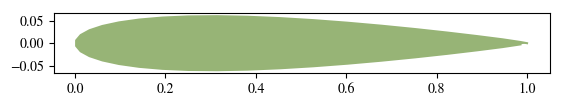

In [65]:
p = Polygon(vert)
plot(p)

In [66]:
vert

39-element Array{Complex{Float64},1}:
      1.0+0.0im       
 0.985383+0.00264447im
  0.94539+0.00862246im
  0.88901+0.0157682im 
  0.82351+0.0235102im 
 0.752405+0.0312625im 
 0.678104+0.0386332im 
 0.602468+0.0453108im 
 0.527021+0.0510149im 
 0.453065+0.0554798im 
  0.38174+0.0584593im 
 0.314069+0.0597429im 
  0.25098+0.0591768im 
         ⋮            
  0.25098-0.0591768im 
 0.314069-0.0597429im 
  0.38174-0.0584593im 
 0.453065-0.0554798im 
 0.527021-0.0510149im 
 0.602468-0.0453108im 
 0.678104-0.0386332im 
 0.752405-0.0312625im 
  0.82351-0.0235102im 
  0.88901-0.0157682im 
  0.94539-0.00862246im
 0.985383-0.00264447im